In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
rank_to_index = {rank: i for i, rank in enumerate(ranks)}
rank_len = len(ranks)

#Helper functions for data processing
def card_to_vec(card):
    raw_rank = card[:-1]
    one_hot_vector = [0] * rank_len
    one_hot_vector[rank_to_index[raw_rank]] = 1
    return one_hot_vector

def hand_to_list(hand):
    '''Takes hand like KH-AC and outputs list of card numbers'''
    hand_list_1 = hand.split("-")
    hand_list_2 = [card_to_vec(card) for card in hand_list_1]
    return hand_list_2

result_mapping = {
    'hit' : 0,
    'stand' : 1,
    'double down' : 2
}

batch_size = 32

# Defining Dataset Class
class Blackjack_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
# Data Processing
hit_stand_dd_df = pd.read_csv('CSVs/hit_stand_dd.csv')

In [4]:
hsd_train_df, hsd_test_df = train_test_split(hit_stand_dd_df, test_size = 0.2)

def clean_up(dataframe_raw):
    # Cleaned hit_stand_dd
    max_len = 7
    dataframe_raw['dealer_upcard'] = dataframe_raw['dealer_upcard'].apply(card_to_vec)
    dataframe_raw['player_hand'] = dataframe_raw['player_hand'].apply(hand_to_list)
    dataframe_raw['result'] = dataframe_raw['result'].map(result_mapping)
    
    zero_vector = [0] * rank_len
    padded_hands = []
    for hand in dataframe_raw['player_hand']:
        if len(hand) < max_len:
            padded_hand = hand + [zero_vector] * (max_len - len(hand))
        else: 
            padded_hand = hand[:max_len]
        padded_hands.append(padded_hand)
    dataframe_raw['player_hand'] = padded_hands

    # Flattening
    dataframe_raw['player_hand'] = dataframe_raw['player_hand'].apply(lambda hand: [item for card_vec in hand for item in card_vec])
    
    # Turning into tensor matrices
    # hit_stand_dd
    x1 = torch.tensor(dataframe_raw['player_hand'].to_list(), dtype=torch.float32)
    x2 = torch.tensor(dataframe_raw['dealer_upcard'].to_list(), dtype=torch.float32)
    x3 = torch.tensor(dataframe_raw['can_double'].values, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(dataframe_raw['result'].values, dtype=torch.long)

    X = torch.cat([x1,x2,x3], dim=1)

    return Blackjack_Dataset(X,y)

hsd_train_dataset = clean_up(hsd_train_df)
hsd_test_dataset = clean_up(hsd_test_df)

hsd_train_dataloader = DataLoader(hsd_train_dataset, batch_size=batch_size, shuffle=True)
hsd_test_dataloader = DataLoader(hsd_test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
train_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    batch_losses = []

    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        batch_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Printing Training Update on every 100th batch
        if (batch + 1) % 100 == 0: 
            loss = loss.item()
            current = batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_losses.append(sum((batch_losses))/len(batch_losses))

test_losses = []
test_accs = []

def test_loop(dataloader, model, loss_fn):
    #Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    #Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for X, y in dataloader: 
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.3f}%, Avg loss: {test_loss:>8f} \n")
    test_accs.append(100*correct)
    test_losses.append(test_loss)

In [11]:
class hsd_NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(105, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

hsd_model = hsd_NeuralNetwork()

learning_rate = 0.02
epochs = 80

loss_fn = nn.CrossEntropyLoss()
hsd_optimizer = torch.optim.SGD(hsd_model.parameters(), lr=learning_rate)

In [12]:
train_losses = []
test_losses = []
test_accs = []

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------")
    train_loop(hsd_train_dataloader, hsd_model, loss_fn, hsd_optimizer)
    test_loop(hsd_test_dataloader, hsd_model, loss_fn)
print("Done!")

Epoch 1
---------------------------
loss: 0.928368  [ 3200/418860]
loss: 1.014588  [ 6400/418860]
loss: 0.984748  [ 9600/418860]
loss: 1.079184  [12800/418860]
loss: 0.911719  [16000/418860]
loss: 0.858564  [19200/418860]
loss: 0.848586  [22400/418860]
loss: 0.993148  [25600/418860]
loss: 0.820319  [28800/418860]
loss: 1.043038  [32000/418860]
loss: 0.713738  [35200/418860]
loss: 0.826983  [38400/418860]
loss: 0.778418  [41600/418860]
loss: 0.683172  [44800/418860]
loss: 0.445262  [48000/418860]
loss: 0.760235  [51200/418860]
loss: 0.711118  [54400/418860]
loss: 0.555818  [57600/418860]
loss: 0.488207  [60800/418860]
loss: 0.476948  [64000/418860]
loss: 0.283967  [67200/418860]
loss: 0.300112  [70400/418860]
loss: 0.534209  [73600/418860]
loss: 0.501308  [76800/418860]
loss: 0.516385  [80000/418860]
loss: 0.511080  [83200/418860]
loss: 0.406314  [86400/418860]
loss: 0.383601  [89600/418860]
loss: 0.407791  [92800/418860]
loss: 0.406223  [96000/418860]
loss: 0.416802  [99200/418860]
los

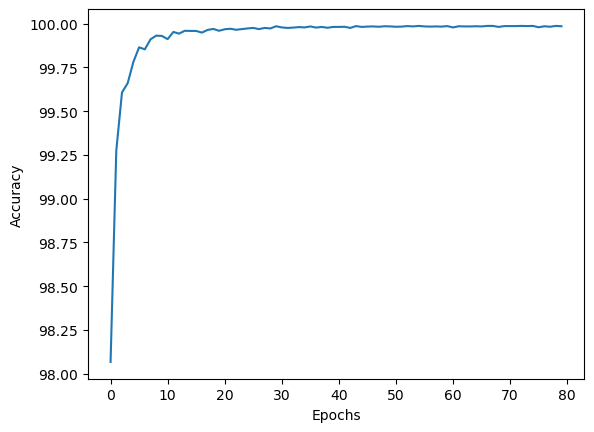

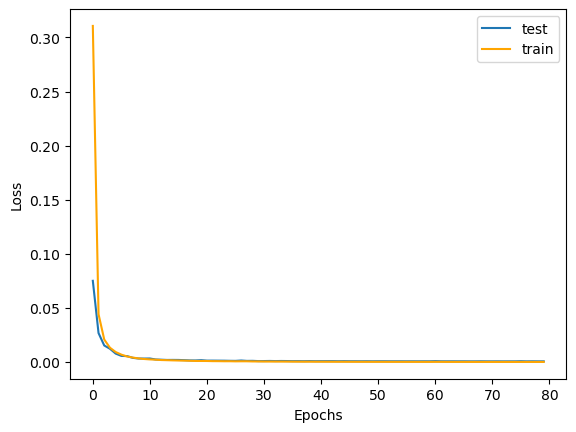

In [8]:
plt.plot(test_accs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(test_losses, color = 'tab:blue', label = 'test')
plt.plot(train_losses, color = 'orange', label = 'train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

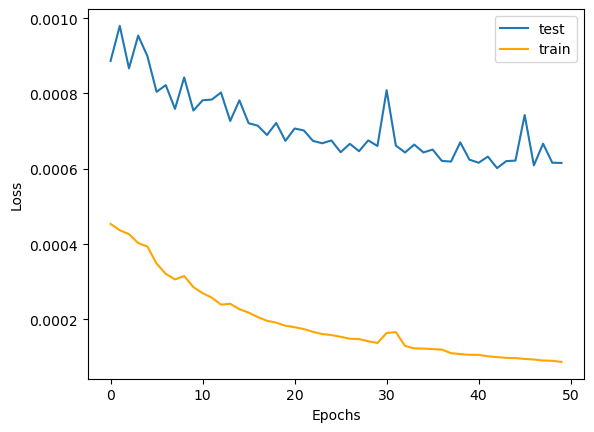

In [9]:
start = 30
plt.plot(test_losses[start:], color = 'tab:blue', label = 'test')
plt.plot(train_losses[start:], color = 'orange', label = 'train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

***Save and Load***

In [88]:
# To save the model that was just trained
torch.save(hsd_model, "hsd_imit_nn.pt")

In [89]:
loaded_model = torch.load("hsd_imit_nn.pt", map_location=torch.device('cpu'))
loaded_model.eval()
test_loop(hsd_test_dataloader, loaded_model,loss_fn)

Test Error: 
 Accuracy: 99.981%, Avg loss: 0.000608 



In [10]:
test_loop(hsd_test_dataloader, hsd_model, loss_fn)

Test Error: 
 Accuracy: 99.985%, Avg loss: 0.000616 



In [ ]:
# Save as weights, in case I need it like this
# torch.save(hsd_model.state_dict(), "hsd_imit_nn_weights.pt")
# loaded_weights_model = hsd_NeuralNetwork()
# loaded_weights = torch.load("hsd_imit_nn_weights.pt")
# loaded_weights_model.load_state_dict(loaded_weights)
# loaded_model.eval()
# test_loop(hsd_test_dataloader, loaded_weights_model, loss_fn)

hsd_NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=105, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)